## Objective
Figure out what causes multiple prop units to detect the same spikes and solve problem

## General setup

In [1]:
%load_ext autoreload

In [8]:
from pathlib import Path
from multiprocessing import Pool

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%autoreload 2 
from src import utils
from src.sorters.prop_signal import PropSignal

In [11]:
CHANS_RMS = utils.chans_rms_si()
RMS_THRESH = 5
##
# plt.hist(CHANS_RMS * RMS_THRESH, bins=25)

# plt.title("Each data point is an electrode")
# plt.xlabel(f"{RMS_THRESH}RMS across entire electrode")
# plt.ylabel("Number of electrodes")
# plt.show()

In [4]:
PROP_SIGNAL = PropSignal("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230718", utils.rec_si())

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


Recording does not have scaled traces. Setting gain to 0.195


In [6]:
prop_units = [p for p in PROP_SIGNAL]

## Examine spike splittng problem

100%|██████████| 97/97 [00:03<00:00, 25.22it/s]


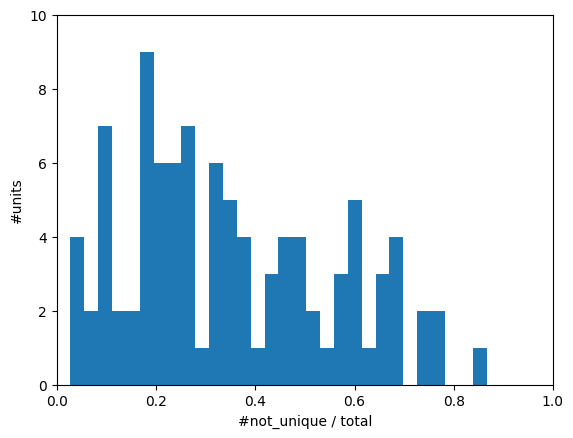

In [16]:
spike_train_sets = []
spike_trains = PROP_SIGNAL.get_spike_times()
for train in spike_trains:
    spike_train_sets.append(set(train))

overlap_ratios = []  # ith value = #not_unique/#total for spikes of ith propagation
overlap_matrix = np.zeros((len(PROP_SIGNAL), len(PROP_SIGNAL)), dtype=float)  # [i, j] = num overlaps between units i and j / num spikes i
for i in tqdm(range(len(PROP_SIGNAL))):
    unique = spike_train_sets[i]
    for j in range(len(PROP_SIGNAL)):
        if i == j:
            continue
        overlap_matrix[i, j] = len(spike_train_sets[i].intersection(spike_train_sets[j])) / len(spike_train_sets[i])
        unique = unique.difference(spike_train_sets[j])
    overlap_ratios.append(
        (len(spike_train_sets[i]) - len(unique)) / (len(spike_train_sets[i]))
    )
    
plt.hist(overlap_ratios, bins=30)
plt.yticks(range(0, 12, 2))

plt.ylabel("#units")
plt.xlabel("#not_unique / total")
plt.xlim(0, 1)
plt.show()
    

In [20]:
most_overlaps = np.argsort(-np.array(overlap_ratios))

## Extract unit templates

In [9]:
NUM_WFS = 300
MS_BEFORE = 2
MS_AFTER = 2

np.random.seed(231)
##
def extract_templates(unit_idx):
    unit = prop_units[unit_idx]
    return unit_idx, unit.get_templates(num_wfs=NUM_WFS, ms_before=MS_BEFORE, ms_after=MS_AFTER)

with Pool(processes=12) as pool:
    for unit_idx, templates in tqdm(pool.imap(extract_templates, range(len(prop_units))), total=len(prop_units)):
        prop_units[unit_idx].templates = templates

100%|██████████| 97/97 [00:38<00:00,  2.52it/s]


## Select units

78


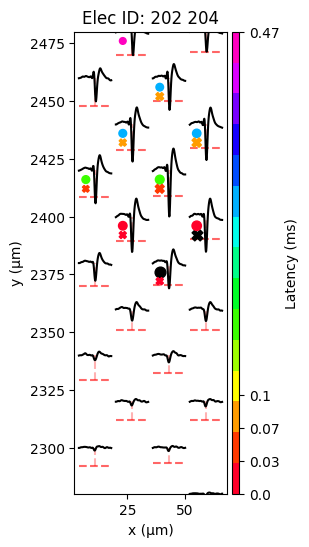

79


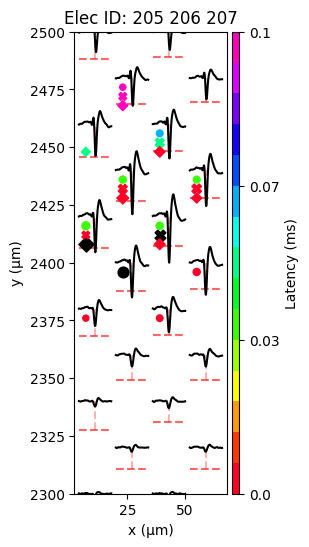

80


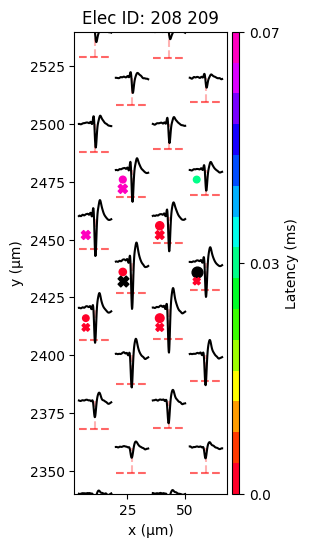

81


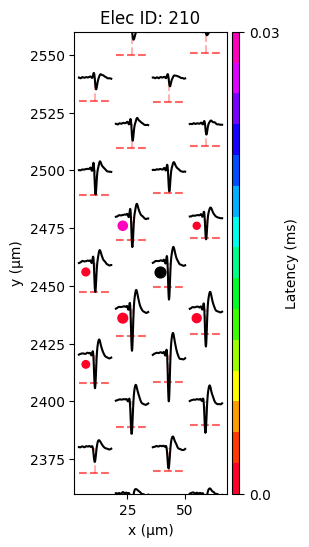

82


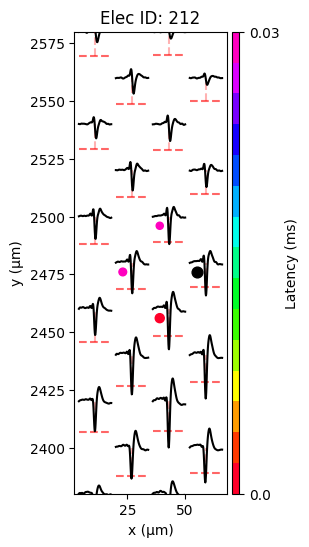

83


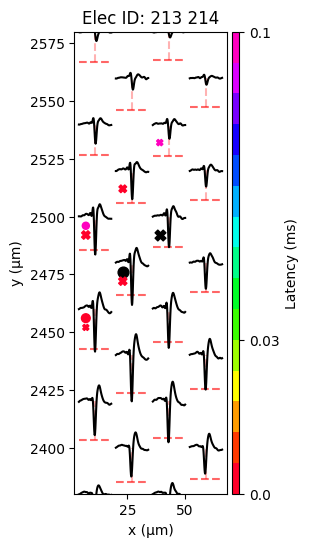

84


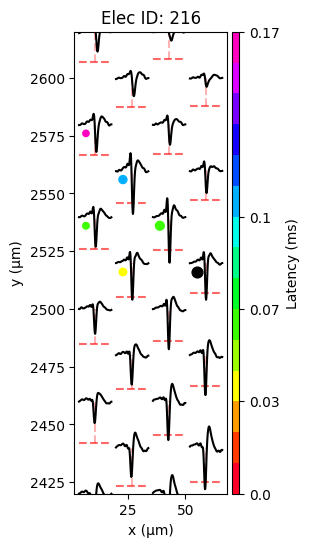

In [27]:
most_idx = most_overlaps[0]
for prop in prop_units[range(most_idx-3, most_idx+4)]:
    print(prop.idx)
    prop.plot(chans_rms=CHANS_RMS)

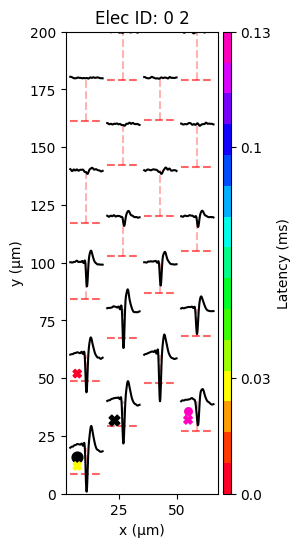

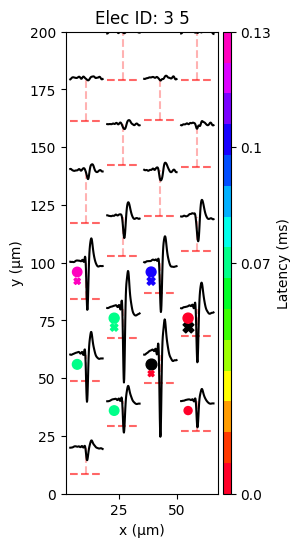

In [13]:
UNIT1 = prop_units[0]
UNIT2 = prop_units[1]

kwargs = UNIT1.plot(chans_rms=CHANS_RMS, return_kwargs=True)
UNIT2.plot(**kwargs)

In [14]:
same_spikes = set(UNIT1.spike_train).intersection(UNIT2.spike_train)
print(
f"""# spikes:
Matches: {len(same_spikes)}
Unit {UNIT1.idx}: {len(UNIT1)}, {len(same_spikes)/len(UNIT1)*100:.1f}%
Unit {UNIT2.idx}: {len(UNIT2)}, {len(same_spikes)/len(UNIT2)*100:.1f}%
""")

# spikes:
Matches: 47
Unit 0: 6878, 0.7%
Unit 1: 3786, 1.2%

